In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve, inv
from scipy.optimize import fsolve

In [2]:
def initial_point(c, theta):
    n  = c.size
    e  = np.ones(n)
    
    x0 = np.zeros(n)
    y0 = e
    z0 = e
    mu0 = 4 * (1 + norm(c) ** 2)
    
    lam0 = mu0 - c / 2
    gam0 = mu0 + c / 2
    
    return x0, y0, z0, lam0, gam0, mu0

In [3]:
def kappa(x, y, z, lam, gam, mu):
    n = c.size
    e = np.ones(n)
    
    rX = H @ x + lam - gam + c
    rY = x + y - np.ones(n)
    rZ = x - z + np.ones(n)
    
    return (norm(rY) + norm(rZ)) / (2 * n)             \
         +  norm(rX) / max(1, norm(c                )) \
         +  mu       / max(1, norm(x @ H @ x + c @ x))

In [4]:
def newton_step(H, lam, y, gam, z):
    Lam = np.diag(lam)
    Gam = np.diag(gam)
    Y   = np.diag(  y)
    Z   = np.diag(  z)
    Yi  = inv(Y)
    B   = Z @ Yi
    A   = B @ Lam + (Gam + Z @ H)

    a = lam * y
    b = gam * z
    
    x_d   = solve(A, b - B @ a)
    y_d   = -x_d
    z_d   =  x_d
    lam_d = Yi @ (Lam @ x_d + a)
    gam_d = lam_d + H @ x_d

    a_dot = -2 * lam_d * y_d
    b_dot = -2 * gam_d * z_d
    
    x_dd   = solve(A, b_dot - B @ a_dot)
    y_dd   = -x_dd
    z_dd   =  x_dd
    lam_dd = Yi @ (Lam @ x_dd - 2 * lam_d * y_d)
    gam_dd = lam_dd + H @ x_dd

    return x_d , y_d , z_d , lam_d , gam_d, \
           x_dd, y_dd, z_dd, lam_dd, gam_dd

In [5]:
def step_along_arc( x   , y   , z   , lam   , gam  \
                  , x_d , y_d , z_d , lam_d , gam_d \
                  , x_dd, y_dd, z_dd, lam_dd, gam_dd \
                  , sin_a, mu): 
    n     = x.size
    cos_a = np.sqrt(1 - sin_a**2)
    upd   = lambda v, v_d, v_dd: v - v_d * sin_a + v_dd * (1 - cos_a)

    p_d  = np.concatenate([  y_d ,   z_d ])
    w_d  = np.concatenate([lam_d , gam_d ])
    p_dd = np.concatenate([  y_dd,   z_dd])
    w_dd = np.concatenate([lam_dd, gam_dd])
    
    mu_a = mu * (1 - sin_a)                                          \
         + (                                                         \
               (p_dd @ w_dd - p_d  @ w_d) *         (1 - cos_a)**2 - \
               (p_d  @ w_dd + p_dd @ w_d) * sin_a * (1 - cos_a)      \
           ) / (2 * n)
    
    return (
        upd(  x,   x_d,   x_dd),
        upd(  y,   y_d,   y_dd),
        upd(  z,   z_d,   z_dd),
        upd(lam, lam_d, lam_dd),
        upd(gam, gam_d, gam_dd),
        mu_a
    )

In [6]:
def correct_step(H, lam_a, y_a, gam_a, z_a, mu_a):
    n = lam_a.size
    e = np.ones(n)

    Lam = np.diag(lam_a)
    Y   = np.diag(  y_a)
    Gam = np.diag(gam_a)
    Z   = np.diag(  z_a)
    Yi  = inv(Y)
    B   = Z @ Yi
    A   = B @ Lam + Gam + Z @ H

    a = mu_a * e - lam_a * y_a
    b = mu_a * e - gam_a * z_a
    
    dx   = solve(A, b - B @ a)
    dy   = -dx
    dz   =  dx
    dlam = Yi @ (Lam @ dx + a)
    dgam = dlam + H @ dx

    return dx, dy, dz, dlam, dgam

def update(x, y, z, lam, gam, mu, H):
    n   = x.size
    upd = lambda v, dv: v + dv
    
    dx, dy, dz, dlam, dgam = correct_step(H, lam, y, gam, z, mu)
    
    x1   = x + dx
    y1   = y + dy
    z1   = z + dz
    lam1 = lam + dlam
    gam1 = gam + dgam
    mu1  = (y1 @ lam1 + z1 @ gam1) / (2 * n)
    
    return x1, y1, z1, lam1, gam1, mu1

In [7]:
def step_size(mu, theta, x_d, p_d, w_d, p_dd, w_dd, sigma):
    n = p_d.size
    e = np.ones(n)
    
    sin_a_flat = fsolve(
        lambda x: mu * (1 - x) - (p_d @ w_d) * (x**4 + x**2) / (2 * n) - sigma,
        0.99
    )
    
    b0 = -theta * mu
    b1 = -b0
    b3 = norm(p_d  * w_dd + w_d * p_dd - (p_d  @ w_dd + w_d @ p_dd) * e / (2 * n)) + theta / n * (p_d  @ w_dd + p_dd @ w_d)
    b4 = norm(p_dd * w_dd - w_d * p_d  - (p_dd @ w_dd - w_d @ p_d ) * e / (2 * n)) - theta / n * (p_dd @ w_dd - p_d  @ w_d)
    
    b0_hat = b0
    b1_hat = b1
    b3_hat = b3 if b3 >= 0 else 0
    b4_hat = b4 if b4 >= 0 else 0
    
    sin_a_wave = fsolve(
        lambda x: (
            b4_hat *     (1 - np.sqrt(1 - x**2))**2 +
            b3_hat * x * (1 - np.sqrt(1 - x**2))    +
            b1_hat * x                              +
            b0_hat
        ),
        0.99
    )
    
    a0 = b0
    a1 = b1
    a2 = theta * (x_d @ (H @ x_d)) / n
    a3 = norm(p_d  * w_dd + w_d * p_dd - (p_d  @ w_dd + w_d @ p_dd) * e / (2 * n))
    a4 = norm(p_dd * w_dd - w_d * p_d  - (p_dd @ w_dd - w_d @ p_d ) * e / (2 * n)) + a2
    
    sin_a_strike = fsolve(
        lambda x: a4 * x**4 + a3 * x**3 + a2 * x**2 + a1 * x + a0,
        0.99
    )
    
    sin_a_galka = max(sin_a_wave, sin_a_strike)
    
    beta  = p_dd @ w_dd / (2 * n * mu)
    bi2   =  1 / (2 * beta)
    one63 = (1 / 6)**3
    
    a_C1_galka = (
        np.pi / 2 if beta <= 1 / 6 else
        np.asin(
            np.cbrt(bi2 + np.sqrt(bi2**2 + one63)) +
            np.cbrt(bi2 - np.sqrt(bi2**2 + one63))
        )
    )
    
    return min(sin_a_flat, sin_a_galka, np.sin(a_C1_galka))

In [18]:
def solve_qp_arcsearch(H, c, theta=0.19, eps=1e-8, sigma=1e-10, max_iter=50):
    x, y, z, lam, gam, mu = initial_point(c, theta)
    k = kappa(x, y, z, lam, gam, mu)

    dual_meas_hist = []
    step_hist      = []
    loss_hist      = []
    gap_hist       = []
    
    for it in range(max_iter):
        if k <= eps:
            break

        # 1) Newton step
        x_d, y_d, z_d, lam_d, gam_d, x_dd, y_dd, z_dd, lam_dd, gam_dd = newton_step(H, lam, y, gam, z)

        # 2) Choose new step
        p_d  = np.concatenate([   y_d,    z_d])
        w_d  = np.concatenate([ lam_d,  gam_d])
        p_dd = np.concatenate([  y_dd,   z_dd])
        w_dd = np.concatenate([lam_dd, gam_dd])
        
        sin_a = step_size(mu, theta, x_d, p_d, w_d, p_dd, w_dd, sigma)

        # 3) Do step along arc
        x_a, y_a, z_a, lam_a, gam_a, mu_a = step_along_arc \
        (
            x   , y   , z   , lam   , gam   , \
            x_d , y_d , z_d , lam_d , gam_d , \
            x_dd, y_dd, z_dd, lam_dd, gam_dd, \
            sin_a, mu                         \
        )

        # 4) Back to proximal vicinity: N(2O) -> N(O)
        x, y, z, lam, gam, mu = update(x_a, y_a, z_a, lam_a, gam_a, mu_a, H)

        # 5) Update kappa for termination criteria
        k = kappa(x, y, z, lam, gam, mu)

        dual_meas_hist.append(mu)
        step_hist     .append(sin_a)
        loss_hist     .append(0.5 * x @ (H @ x) + c @ x)
        gap_hist      .append(k)
        
        #print("mu: ", mu)
        #print("Kappa: ", k)
        #print("Step: ", sin_a)
    return x, dual_meas_hist, step_hist, loss_hist, gap_hist

In [7]:
import numpy as np

def compute_lqr_matrices_optimized(A, B, P, Q, R, x0, N):
    """
    Computes H and c matrices for the LQR problem with horizon N, optimized for matrix powers.
    
    Parameters:
    - A  (ndarray): State transition matrix (r x r)
    - B  (ndarray): Input            matrix (r x m)
    - P  (ndarray): Terminal cost    matrix (r x r)
    - Q  (ndarray): State    cost    matrix (r x r)
    - R  (float  ): Control  cost    scalar
    - x0 (ndarray): Initial  state   vector (r x 1)
    - N  (int    ): Horizon length
    
    Returns:
    - H (ndarray): Quadratic cost matrix (N*m x N*m)
    - c (ndarray): Linear    cost vector (N*m x 1  )
    """
    r, m = B.shape
    
    powers = [B]
    for i in range(1, N):
        powers.append(A @ powers[-1])  # [B, A B, A^2 B, ..., A^{N-1} B]
    
    x_k = [x0]
    for k in range(1, N + 1):
        x_k.append(A @ x_k[-1])  # [x0, A x0, A^2 x0, ..., A^N x0]
    
    # Compute phi_N = [A^{N-1} B, A^{N-2} B, ..., B]
    phiN = np.hstack(powers[::-1])
    H    = phiN.  T @ P @ phiN  # Terminal cost contribution
    c    = x_k[N].T @ P @ phiN  # Terminal cost linear term
    
    # Stage costs
    for k in range(1, N):
        # phi_k = [A^{k-1} B, A^{k-2} B, ..., B]
        phi_k = np.hstack(powers[:k][::-1])
        H[:k*m, :k*m] += phi_k. T @ Q @ phi_k  # Stage cost quadratic term
        c[:k*m      ] += x_k[k].T @ Q @ phi_k  # Stage cost linear term
    
    H += np.eye(N*m) * R  # Control cost contribution
    c = c.flatten()
    return H, c

In [70]:
T = 50.0
N = 1000
h = T / N

# System matrices
A = np.array([[1, h], [-h, 1]])
B = np.array([[0], [h]])

#for sliding mode
C = np.array([1, 2])

# Cost weights
P = np.array([[2, 0], [0, 1]])
Q = P.copy()
R = 6.0

# Initial state
x0 = np.array([15.0, 5.0])

#Target state 
x_target = np.array([0.0, 0.0])

# Compute H and c
H, c = compute_lqr_matrices_optimized(A, B, P, Q, R, x0, N)

In [19]:
# Solve using arc-search QP
u_opt, dual_meas, step, loss, gap = solve_qp_arcsearch(H, c, theta=0.19, eps=1e-8, sigma=1e-10, max_iter=100)

NameError: name 'initial_point' is not defined

In [67]:
# PID

class PIDController:
    def __init__(self, K_p, K_d, h, output_limits=(-float('inf'), float('inf'))):
        self.K_p = K_p
        self.K_d = K_d
        self.h = h
        self.last_error = 0.0
        self.min_output, self.max_output = output_limits
        self.loss = 0.0
         

    def update(self, x_current, x_target):
        error = x_current - x_target
       
        P = self.K_p * error
        D = self.K_d * (error - self.last_error) / self.h
        self.last_error = error
        u = P + D

        u_clamped = np.clip(u, self.min_output, self.max_output)
        self.loss = 0.5 * u @ u
        return u_clamped, self.loss

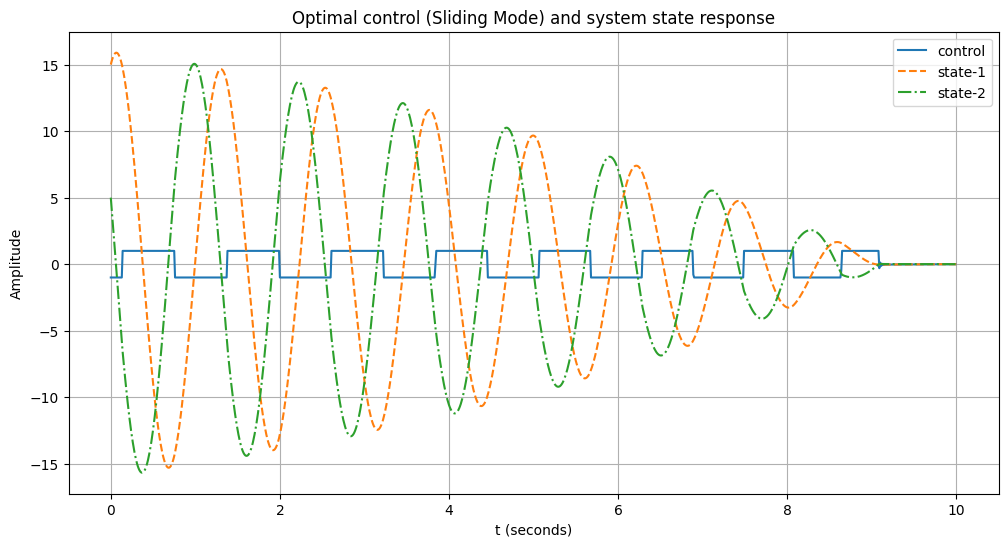

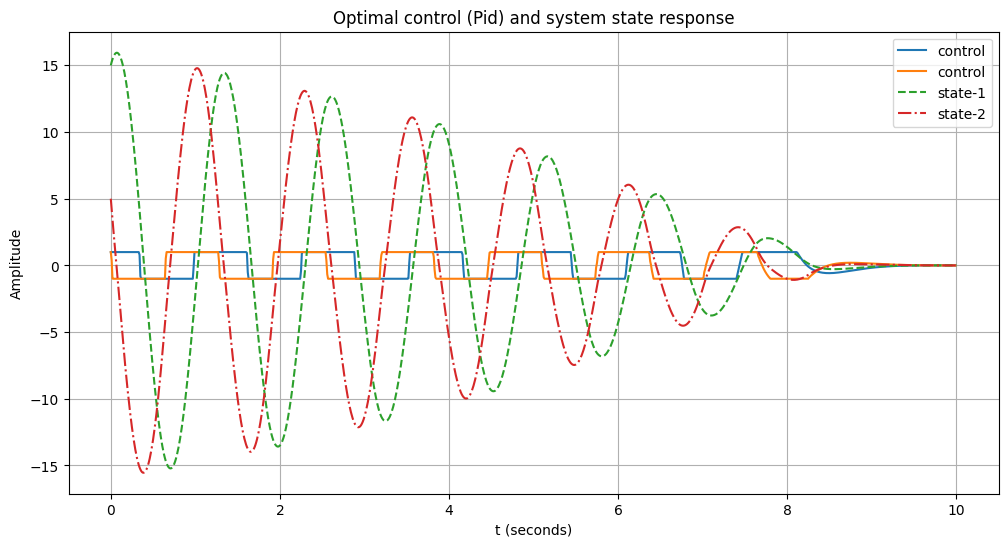

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_control_system(control_type='sliding_mode'):


    x_traj = np.zeros((2, N + 1))
    x_traj[:, 0] = x0
    
    u_opt = []
    
    if control_type == 'pid':

        class PIDController:
            def __init__(self, K_p, K_d, h, output_limits=(-float('inf'), float('inf'))):
                self.K_p = K_p
                self.K_d = K_d
                self.h = h
                self.last_error = 0.0
                self.min_output, self.max_output = output_limits
                self.loss = 0.0
                

            def update(self, x_current, x_target):
                error = x_current - x_target
            
                P = self.K_p * error
                D = self.K_d * (error - self.last_error) / self.h
                self.last_error = error
                u = P + D

                u_clamped = np.clip(u, self.min_output, self.max_output)
                self.loss = 0.5 * u @ u
                return u_clamped, self.loss
      
        pid = PIDController(K_p=2.0, K_d=0.5, h=h, output_limits=(-1, 1))
        
        for k in range(N):
            u, loss = pid.update(x_traj[:, k], x_target)
            u_opt.append(u)
            x_traj[:, k + 1] = A @ x_traj[:, k] - B.flatten() * u
            
    elif control_type == 'sliding_mode':
        class SlidingMode:
            def __init__(self, A, B, C, K=0.5, phi=0.1, output_limits=(-1, 1)):
                self.A = A
                self.B = B
                self.C = C
                self.K = K
                self.phi = phi
                self.min_output, self.max_output = output_limits

            def update(self, x):
                s = self.C @ x
                CB = self.C @ self.B
                
                if np.abs(CB) < 1e-6:
                    u_eq = 0.0
                else:
                    u_eq = - (1 / CB) * (self.C @ self.A @ x)
                
                u_sw = - self.K * np.tanh(s / self.phi)  
                u = u_eq + u_sw
                return np.clip(u, self.min_output, self.max_output)
        
         # s = x1 + 0.5*x2
        sliding = SlidingMode(A, B, C, K=0.5, phi=0.08)
        
        for k in range(N):
            u = sliding.update(x_traj[:, k])
            u_opt.append(u)
            x_traj[:, k + 1] = A @ x_traj[:, k] + B.flatten() * u
    
    return t, x_traj, u_opt

def plot_control_results(t, x_traj, u_opt, control_type):
    plt.figure(figsize=(12,6))
    plt.plot(t[:-1], u_opt, label='control')
    plt.plot(t, x_traj[0, :], '--', label='state-1')
    plt.plot(t, x_traj[1, :], '-.', label='state-2')
    plt.xlabel('t (seconds)')
    plt.ylabel('Amplitude')
    plt.title(f'Optimal control ({control_type.replace("_", " ").title()}) and system state response')
    plt.legend()
    plt.grid(True)

t, x_traj, u_opt = simulate_control_system(control_type='sliding_mode')
plot_control_results(t, x_traj, u_opt, 'sliding_mode')

t, x_traj, u_opt = simulate_control_system(control_type='pid')
plot_control_results(t, x_traj, u_opt, 'pid')



[-238.]
[19.8875]
[18.06875]
[18.44300781]
[17.46569727]
[17.35170193]
[16.71625495]
[16.42438259]
[15.93500177]
[15.58585876]
[15.16544227]
[14.80553748]
[14.4233795]
[14.07030722]
[13.71385441]
[13.37394251]
[13.03775991]
[12.71296218]
[12.39442171]
[12.08500893]
[11.78260385]
[11.48821367]
[11.20089901]
[10.92094485]
[10.64787853]
[10.38170826]
[10.12214887]
[9.86910557]
[9.62237142]
[9.38181621]
[9.14726825]
[8.91858814]
[8.69562244]
[8.4782325]
[8.2662763]
[8.05961964]
[7.85812899]
[7.66167586]
[7.47013391]
[7.2833806]
[7.10129606]
[6.92376367]
[6.75066957]
[6.58190284]
[6.41735526]
[6.25692138]
[6.10049835]
[5.94798589]
[5.79928624]
[5.65430409]
[5.51294648]
[5.37512282]
[5.24074475]
[5.10972613]
[4.98198298]
[4.8574334]
[4.73599757]
[4.61759763]
[4.50215769]
[4.38960375]
[4.27986365]
[4.17286706]
[4.06854539]
[3.96683175]
[3.86766096]
[3.77096943]
[3.6766952]
[3.58477782]
[3.49515837]
[3.40777941]
[3.32258493]
[3.2395203]
[3.1585323]
[3.07956899]
[3.00257976]
[2.92751527]
[2.854

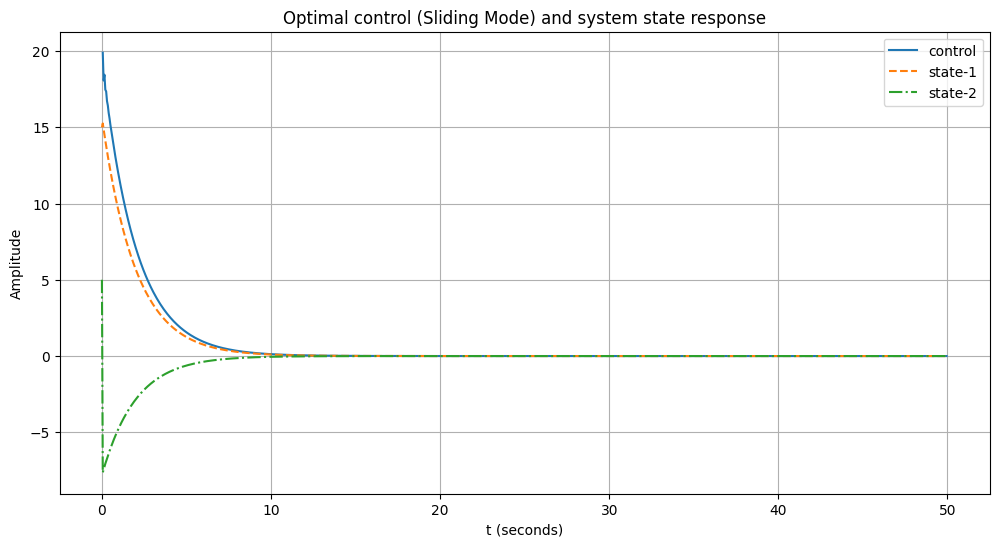

In [ ]:
# time axis
t = np.linspace(0, T, N + 1)
x_traj = np.zeros((2, N + 1))
x_traj[:, 0] = x0

u_opt = []
loss_all = []
pid = PIDController(K_p=2.0, K_d=0.5, h=h, output_limits=(-1, 1))

for k in range(N):
   # u = u_opt[k]
    #u, loss = pid.update(x_traj[:, k], x_target)
    #x_traj[:, k + 1] = A @ x_traj[:, k] + B.flatten() * u
    #u = sliding.update(x_traj[:, k])
    u_opt.append(u)
    #loss_all.append(loss)
    x_traj[:, k + 1] = A @ x_traj[:, k] + B.flatten() * u

loss_all = np.array(loss_all)
# plot
plt.figure(figsize=(12,6))
plt.plot(t[1:-1], u_opt[1:], label='control')
plt.plot(t, x_traj[0, :], '--', label='state-1')
plt.plot(t, x_traj[1, :], '-.', label='state-2')
plt.xlabel('t (seconds)')
plt.ylabel('Amplitude')
plt.title('Optimal control (Sliding Mode) and system state response')
plt.legend()
plt.grid(True)
plt.show()

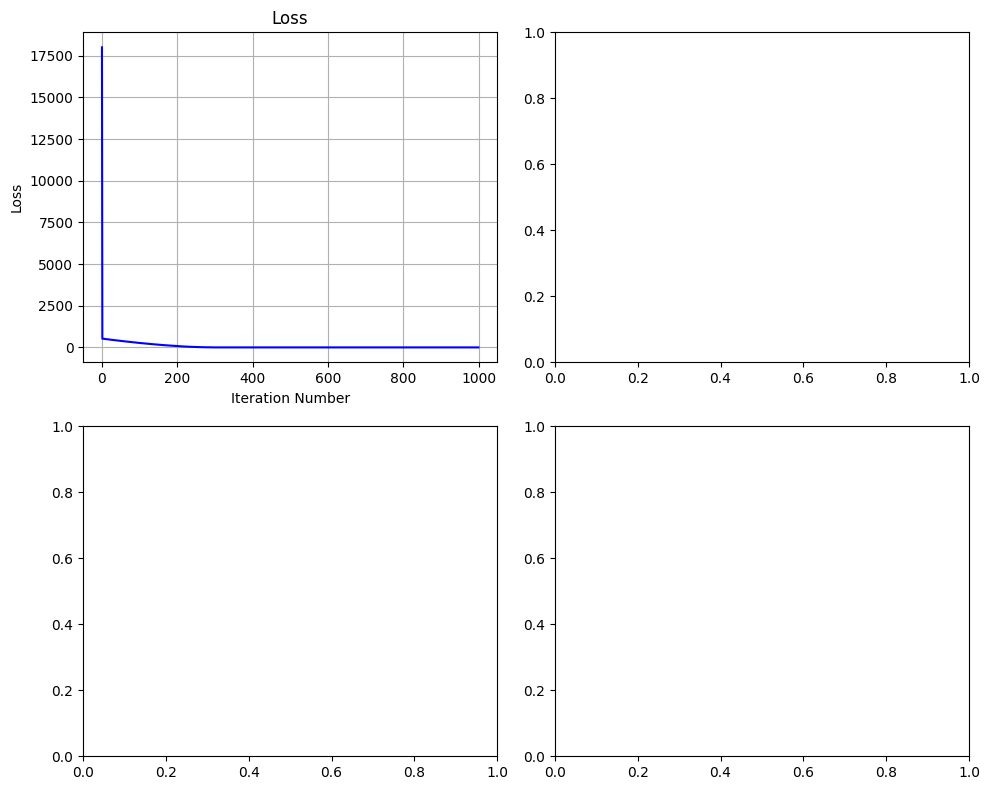

In [49]:
# Create iteration numbers for x-axis
iterations = np.arange(len(loss_all))

# Create a figure with 4 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # Flatten to easily iterate over subplots

# List of parameters and their names
#parameters = [dual_meas, step, loss, gap]
parameters = [loss_all]
#param_names = ['Dual Measure', 'Step', 'Loss', 'Gap']
param_names = ['Loss']
# Plot each parameter in its subplot
for i, (param, name) in enumerate(zip(parameters, param_names)):
    axes[i].plot(iterations, param, 'b-')
    axes[i].set_title(name)
    axes[i].set_xlabel('Iteration Number')
    axes[i].set_ylabel(name)
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.show()